In [80]:
import xarray as xr
import numpy  as np
import pandas as pd

# !pip install OpenVisusNoGui
import OpenVisus as ov

# see https://xarray.pydata.org/en/stable/internals/how-to-add-new-backend.html


# ////////////////////////////////////////////////////////////
class OpenVisusBackendArray(xr.backends.common.BackendArray):
#     TODO: add num_refinements,quality
#     TODO: adding it for normalized coordinates 

    # constructor
    def __init__(self,db, shape, dtype, timesteps,resolution,ncomponents):
        self.db    = db
        self.shape = shape
        self.dtype = dtype
        self.ncomponents=ncomponents
        self.pdim=db.getPointDim()
        self.timesteps=timesteps
        self.resolution=resolution
        

    # __getitem__
    def __getitem__(self, key: xr.core.indexing.ExplicitIndexer) -> np.typing.ArrayLike:
        return xr.core.indexing.explicit_indexing_adapter(key,self.shape,
                                                          xr.core.indexing.IndexingSupport.BASIC,
                                                          self._raw_indexing_method)

    # _getKeyRange
    def _getKeyRange(self, value):
        A = value.start if isinstance(value, slice) else value    ; A = 0             if A is None else A
        B = value.stop  if isinstance(value, slice) else value + 1; B = self.shape[1] if B is None else B
        return (A,B)
    # __readSamples
    def _raw_indexing_method(self, key: tuple) -> np.typing.ArrayLike:
        print("_raw_indexing_method","key",key)

        if self.pdim==2:
            
            y1,y2=self._getKeyRange(key[2])
            x1,x2=self._getKeyRange(key[3])
            
            if type(self.resolution)==int:

                res2=self.resolution
            else:
                res1,res2=self._getKeyRange(key[1])
            
            
            if type(self.timesteps)==int:
                res2-=1

                data=self.db.read(time=self.timesteps,max_resolution=res2, logic_box=[(x1,y1),(x2,y2)])
                
            else:
                t1,t2=self._getKeyRange(key[0])
                if type(t2) ==int and type(res2)==int:
                    res2-=1
                    t2-=1

                    data=self.db.read(time=t2,max_resolution=res2,logic_box=[(x1,y1),(x2,y2)])
                else:
                    data=self.db.read(logic_box=[(x1,y1),(x2,y2)])   
                      
            

        elif self.pdim==3:
            
            
            if type(self.resolution)==int:
                res2=self.resolution
            else:
                res1,res2=self._getKeyRange(key[1])
            

            z1,z2=self._getKeyRange(key[2])
            y1,y2=self._getKeyRange(key[3])
            x1,x2=self._getKeyRange(key[4])

            if type(self.timesteps)==int:
                res2-=1
                data=self.db.read(time=self.timesteps,max_resolution=res2, logic_box=[(x1,y1,z1),(x2,y2,z2)])
                
            else:
                t1,t2=self._getKeyRange(key[0])
                if type(t2) == int and type(res2)==int:
                    res2-=1
                    t2-=1
                    data=self.db.read(time=t2, max_resolution=res2,logic_box=[(x1,y1,z1),(x2,y2,z2)])
                else:
                    data=self.db.read(logic_box=[(x1,y1,z1),(x2,y2,z2)]) 
                

        else:
            raise Exception("problem")

#         # last key element is the channel
        if self.ncomponents>1:
            c1,c2=self._getKeyRange(key[-1])

            # Y,X,Channel
            if self.pdim==2:
                data=data[:,:,c1:c2]

            # Z,Y,X,Channel
            elif self.pdim==3:

                data=data[:,:,:,c1:c2]

            else:
                raise Exception("problem")

        return data




# ////////////////////////////////////////////////////////////
class OpenVisusBackendEntrypoint(xr.backends.common.BackendEntrypoint):

    open_dataset_parameters = ["filename_or_obj", "drop_variables", "resolution", "timesteps"]
    
    # open_dataset
    def open_dataset(self,filename_or_obj,*, resolution=None, timesteps=None,drop_variables=None):

        # TODO for now only full resoluton
        self.resolution=resolution
        # TODO for now only default timestep

        data_vars={}

        db=ov.LoadDataset(filename_or_obj)
#         print(db.getMaxResolution())
        self.timesteps=timesteps
        dim=db.getPointDim()
        dims=db.getLogicSize()
        if self.timesteps==None: 
            self.timesteps=[int(it) for it in db.getTimesteps().asVector()]
            
#         if self.resolution==None: 
#             self.resolution=
#         print(timesteps)

#         print(db.getDatasetBody().toString())
#         print("dim",dim, "dims",dims)

        # convert OpenVisus fields into xarray variables
        for fieldname in db.getFields():
            field=db.getField(fieldname)
            
            ncomponents=field.dtype.ncomponents()
            atomic_dtype=field.dtype.get(0)

            # note: OpenVisus can have dtype uint8[3],numpy cannot
            # for this reason for example
            # 1024x768     uint8       becomes (768,1024)      np.uint8    (NOTE I don't have to add anything to the shape)
            # 1024x768     uint8[3]    becomes (768,1024,3)    np.uint8    (NOTE I am adding a '3' to the shape)
            # 100x200x300  float64     becomes (300,200,100)   np.float64  (NOTE I don't have to add anything to the shape)
            # 100x200x300  float64[2]  becomes (300,200,100,2) np.float64  (NOTE I am adding a '2' to the shape)

            dtype=self.toNumPyDType(atomic_dtype) 

            if dim==2:
                labels=["y", "x"]
            elif dim==3:
                labels=["z", "y", "x"]
            else:
                raise Exception("assigning labels error")


            shape=list(reversed(dims))
            if ncomponents>=1:
                
                labels.insert(0,"resolution")
                labels.insert(0,"time")
                labels.append("channel")
                shape.append(ncomponents)
                if type(self.resolution) == int:
                    shape.insert(0,self.resolution)  
                else:
                    shape.insert(0,db.getMaxResolution())
                if type(self.timesteps) == int:
                    shape.insert(0,self.timesteps)  
                else:
                    shape.insert(0,len(self.timesteps))
                    


            data_vars[fieldname]=xr.Variable(
                labels, 
                xr.core.indexing.LazilyIndexedArray(OpenVisusBackendArray(db=db, shape=shape,dtype=dtype,
                                                                          timesteps=self.timesteps,
                                                                          resolution=self.resolution,
                                                                          ncomponents=ncomponents)), 
                attrs={} # no attributes
            )

            print("Adding field",fieldname,"shape",shape,"dtype",dtype,"labels",labels,"timesteps",self.timesteps,
                 "Max Resolution", db.getMaxResolution())

        ds = xr.Dataset(data_vars=data_vars)
        ds.set_close(self.close_method)
        
        return ds
    
    # toNumPyDType (always pass the atomic OpenVisus type i.e. uint8[8] should not be accepted)
    def toNumPyDType(self,atomic_dtype):
        """
        convert an Openvisus dtype to numpy dtype
        """

        # dtype  (<: little-endian, >: big-endian, |: not-relevant) ; integer providing the number of bytes  ; i (integer) u (unsigned integer) f (floating point)
        return np.dtype("".join([
            "|" if atomic_dtype.getBitSize()==8 else "<",
            "f" if atomic_dtype.isDecimal() else ("u" if atomic_dtype.isUnsigned() else "i"),
            str(int(atomic_dtype.getBitSize()/8))
        ])) 

    # close_method
    def close_method(self):
        print("nothing to do here")
    
    # guess_can_open
    def guess_can_open(self, filename_or_obj):
        print("guess_can_open",filename_or_obj)

        # this are remote datasets
        # todo: extend to S3 datasets
        if "mod_visus" in filename_or_obj:
            return True
         
        # local files
        try:
            _, ext = os.path.splitext(filename_or_obj)
        except TypeError:
            return False
        return ext.lower()==".idx"


In [81]:
import matplotlib.pyplot as plt
def ShowData(data):
    fig = plt.figure(figsize = (70,20))
    ax = fig.add_subplot(1,1,1)
    ax.imshow(data, origin='lower')
    plt.show()
    

Adding field data shape [12, 33, 43200, 86400, 3] dtype uint8 labels ['time', 'resolution', 'y', 'x', 'channel'] timesteps [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11] Max Resolution 33
_raw_indexing_method key (10, 21, slice(25000, 33000, 1), slice(20000, 27000, 1), slice(None, None, None))
(125, 109, 3)


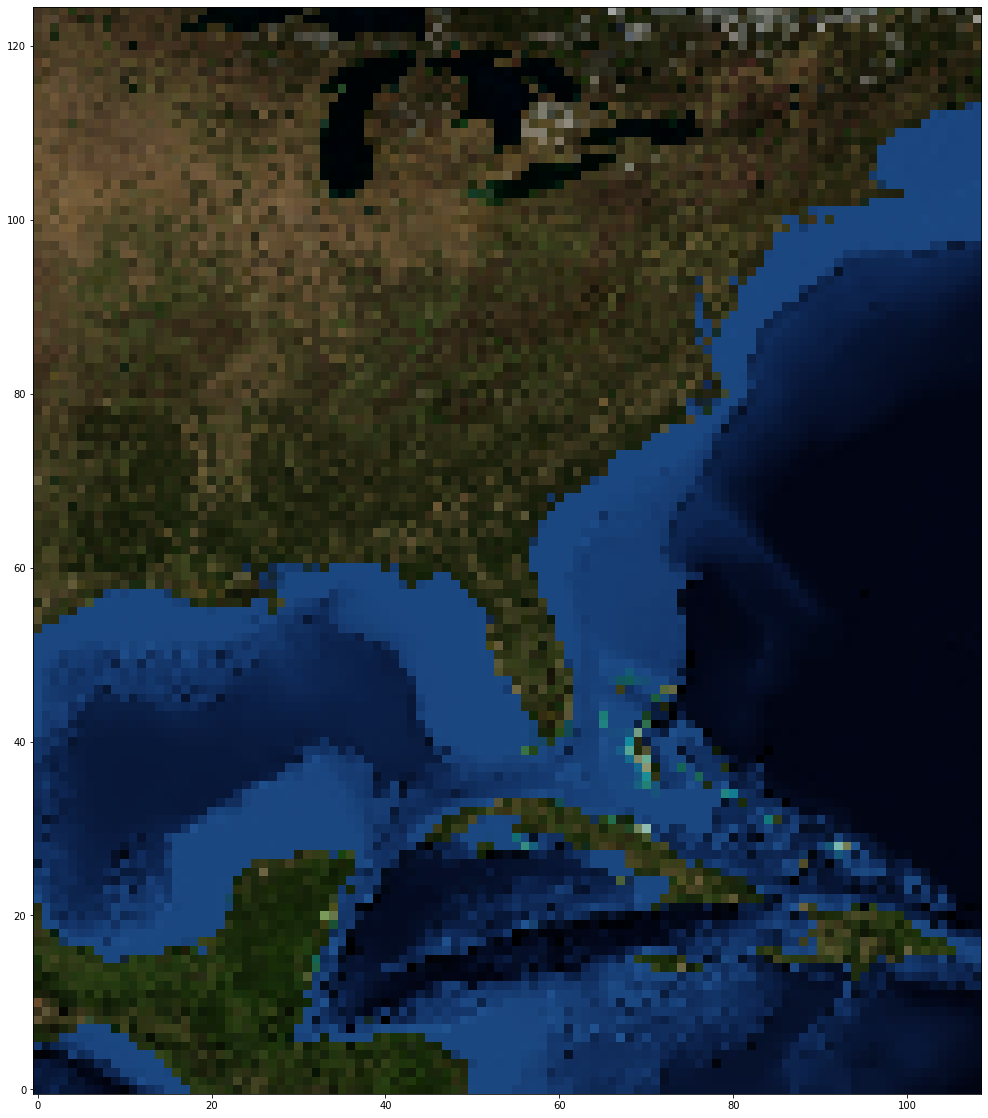

CPU times: user 472 ms, sys: 144 ms, total: 616 ms
Wall time: 435 ms


In [82]:
%%time
ds = xr.open_dataset("http://atlantis.sci.utah.edu/mod_visus?dataset=BlueMarble",engine=OpenVisusBackendEntrypoint)
data=ds.data[10,21,25000:33000,20000:27000,:].values
print(data.shape)
ShowData(data)


_raw_indexing_method key (11, 21, slice(25000, 33000, 1), slice(20000, 27000, 1), slice(None, None, None))
(125, 109, 3)


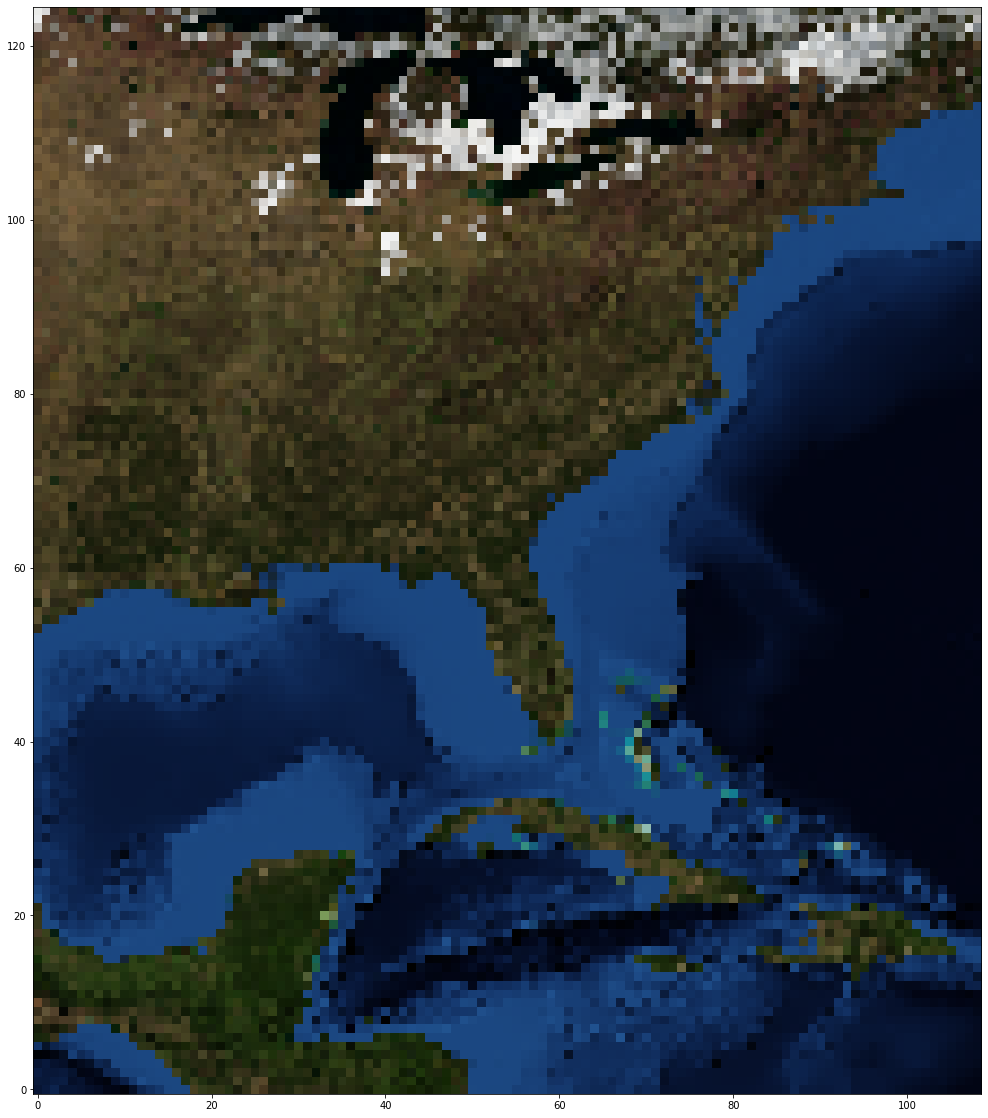

CPU times: user 438 ms, sys: 142 ms, total: 579 ms
Wall time: 407 ms


In [83]:
%%time
data=ds.data[11,21,25000:33000,20000:27000,:].values
print(data.shape)
ShowData(data)

In [84]:
%%time
db=xr.open_dataset('http://atlantis.sci.utah.edu/mod_visus?dataset=david_subsampled', engine=OpenVisusBackendEntrypoint)


# data=db.data[3,30,5000:15000,5000:15000,:].values
# print(data.shape)
# # ShowData(data)


Adding field data shape [4, 32, 70416, 29280, 3] dtype uint8 labels ['time', 'resolution', 'y', 'x', 'channel'] timesteps [0, 1, 2, 3] Max Resolution 32
CPU times: user 109 ms, sys: 31.2 ms, total: 140 ms
Wall time: 138 ms


Adding field DATA shape [1, 33, 2048, 2048, 2048, 1] dtype uint8 labels ['time', 'resolution', 'z', 'y', 'x', 'channel'] timesteps [0] Max Resolution 33
_raw_indexing_method key (0, 30, slice(1000, 1018, 1), slice(0, 2048, 1), slice(0, 2048, 1), 0)


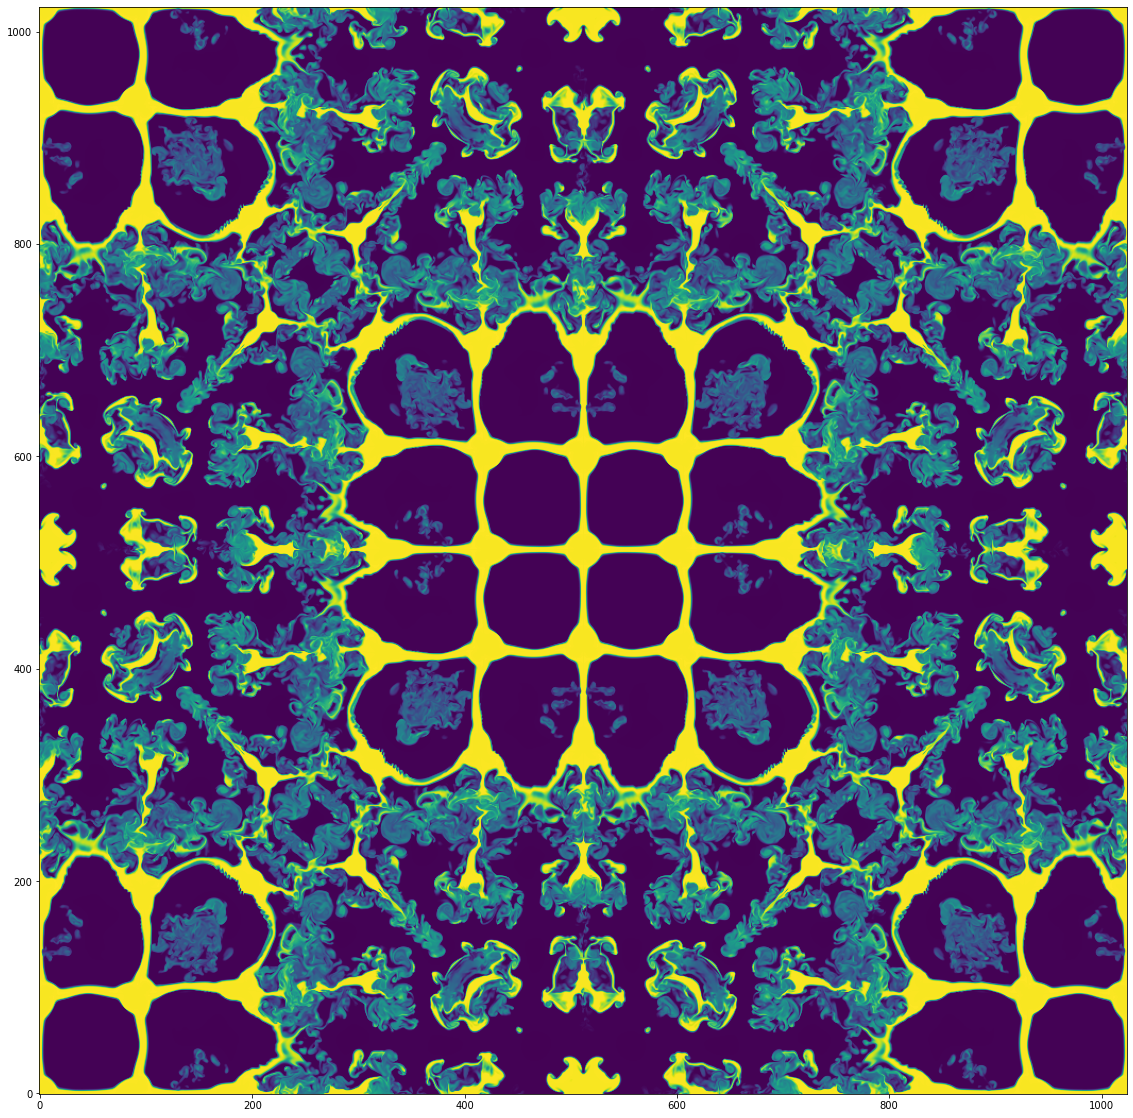

CPU times: user 2.8 s, sys: 1.09 s, total: 3.89 s
Wall time: 3.7 s


In [85]:
%%time
db2=xr.open_dataset('http://atlantis.sci.utah.edu/mod_visus?dataset=2kbit1', engine=OpenVisusBackendEntrypoint)
select_db2=db2.sel(time=0,resolution=30,x=slice(0,2048),y=slice(0,2048),z=slice(1000,1018),channel=0).to_array()

ShowData(select_db2[0][0].values)


In [77]:
# %%time
# db2=xr.open_dataset('http://atlantis.sci.utah.edu/mod_visus?dataset=2kbit1', engine=OpenVisusBackendEntrypoint)
# print(type(db2))
# data=db2.data[:,30,0:2040,0:2040,1020:1022,:].values
# ShowData(data)
# # select_db2=db2.sel(x=slice(0,2048),y=slice(0,2048),z=slice(1020,1025)).to_array()
# # data=db2.data[30,0:2048,0:2048,1024:1025,:].values

# print(data.shape)
# # ShowData(select_db2[0][0].values)